In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

from src.utils import *
from src.datatype import MRIDataset
from src.renderer import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans

In [8]:
patient_id = "005" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"
# dataset = MRIDataset([image_path / t1_file], "T1", axis=0)

In [9]:
dataset = MRIDataset([image_path / t1_file, image_path / t2_file], "T1", axis=0)

In [10]:
T1 = dataset[0]
T1_volume = T1["image"].squeeze(0)       # (D,H,W)
T2 = dataset[1]
T2_volume = T2["image"].squeeze(0)       # (D,H,W)

In [11]:
# Plot histograms
def plot_histogram(volume):
    plt.figure(figsize=(12, 6))

    plt.hist(volume.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title('T1 Volume Intensity Distribution')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    # plt.xlim(0,20)

    plt.tight_layout()
    plt.show()

In [12]:
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion

def create_brain_mask(volume, threshold=50):
    """
    Quick brain mask generation by thresholding and cleaning.
    volume: np.ndarray, MRI volume
    threshold: int, intensity below which is considered air/background
    """
    mask = volume > threshold
    mask = binary_dilation(mask, iterations=2) # pourquoi?
    mask = binary_erosion(mask, iterations=2) # pourquoi? 
    return torch.from_numpy(mask)

def zscore_normalize(volume, mask):
    """
    Normalize a volume by z-scoring inside a brain mask.
    Args:
        volume: torch.Tensor, the 3D volume to normalize.
        mask: torch.Tensor, binary brain mask of the same shape as the volume.
    
    Returns:
        torch.Tensor: The z-score normalized volume.
    """
    volume = volume.float()
    brain_voxels = volume[mask > 0]
    mean = brain_voxels.mean()
    std = brain_voxels.std()
    
    volume_norm = (volume - mean) / (std + 1e-8)  
    return volume_norm



In [13]:
import torch.nn as nn

class ImpedanceEstimator(nn.Module):
    """MLP for estimating acoustic impedance from normalized intensity values."""
    def __init__(self, input_dim: int = 1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    @classmethod
    def train_model(cls,
                    X: torch.Tensor,
                    y: torch.Tensor,
                    input_dim: int = 1,
                    lr: float = 1e-3,
                    epochs: int = 5000) -> 'ImpedanceEstimator':
        """Train impedance estimation model on paired data."""
        model = cls(input_dim)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = nn.MSELoss()
        
        for _ in range(epochs):
            optimizer.zero_grad()
            loss = loss_fn(model(X), y)
            loss.backward()
            optimizer.step()
            
        return model

    @staticmethod
    def compute_impedance_volume(
        volume: torch.Tensor,
        model: 'ImpedanceEstimator',
        threshold: float = 50
    ) -> torch.Tensor:
        """Generate full impedance volume using trained model and preprocessing."""
        mask = create_brain_mask(volume, threshold)
        vol_norm = zscore_normalize(volume.float(), mask)
        
        with torch.no_grad():
            Z_pred = model(vol_norm[mask].unsqueeze(1)).squeeze() * 1e6
            
        Z_vol = torch.full_like(volume, 400.0)  # Default air impedance
        Z_vol[mask] = Z_pred
        return Z_vol

In [14]:
T1_volume = T1_volume.float()

t1 = np.array([-2.0, -1.0, 0.0,  1.5]).reshape(-1,1)
t2 = np.array([-2.0, -0.5, 0.0,  2.0]).reshape(-1,1)
z1 = np.array([400,  1.52e6, 1.7e6, 1.38e6]).reshape(-1,1)/1e6
z2 = np.array([400,  1.38e6, 1.7e6, 1.52e6]).reshape(-1,1)/1e6

X1 = torch.tensor(t1, dtype=torch.float32)
Y1 = torch.tensor(z1, dtype=torch.float32)
X2 = torch.tensor(t2, dtype=torch.float32)
Y2 = torch.tensor(z2, dtype=torch.float32)

model_t1 = ImpedanceEstimator.train_model(X1, Y1, input_dim=1)
model_t2 = ImpedanceEstimator.train_model(X2, Y2, input_dim=1)

Z_vol = ImpedanceEstimator.compute_impedance_volume(T1_volume, model_t1, threshold=50)

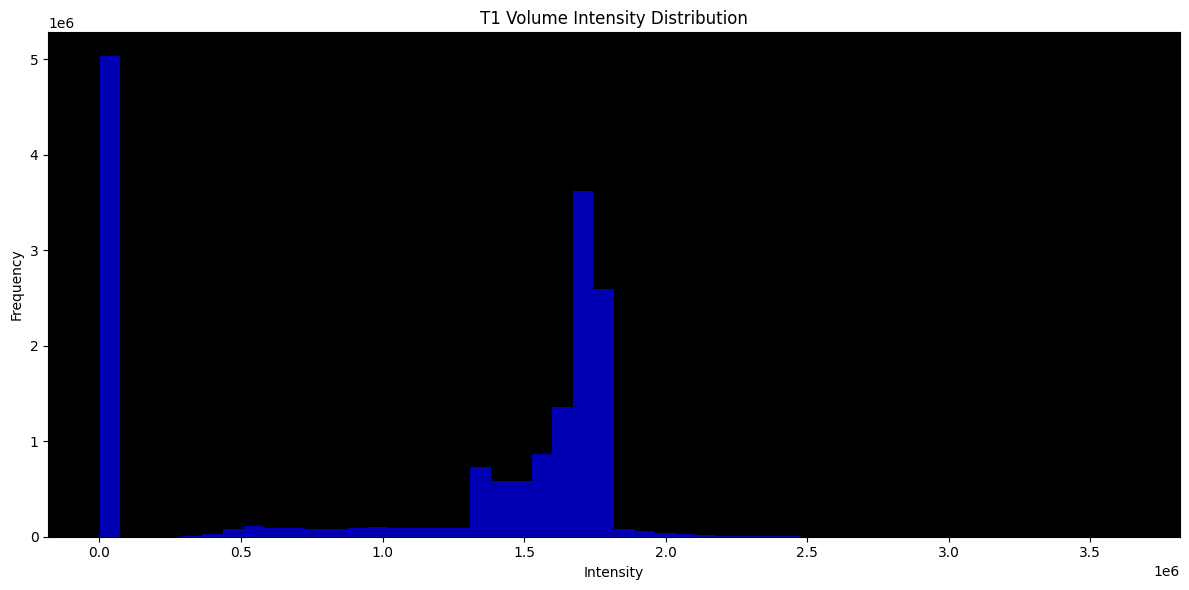

In [46]:
plot_histogram(Z_vol)

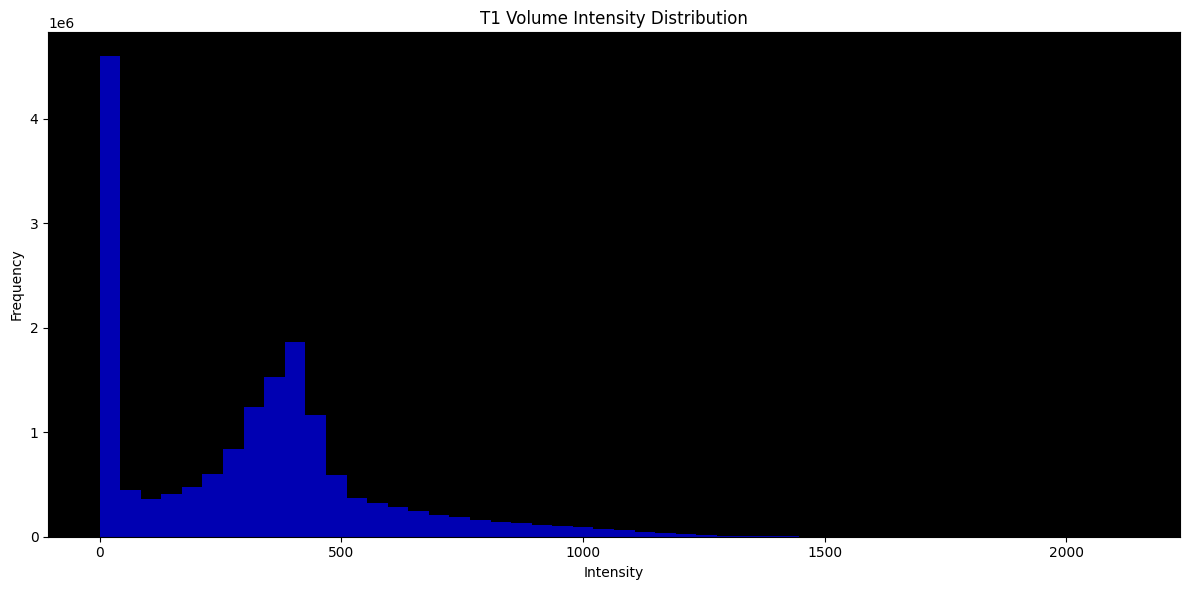

In [47]:
plot_histogram(T1_volume)

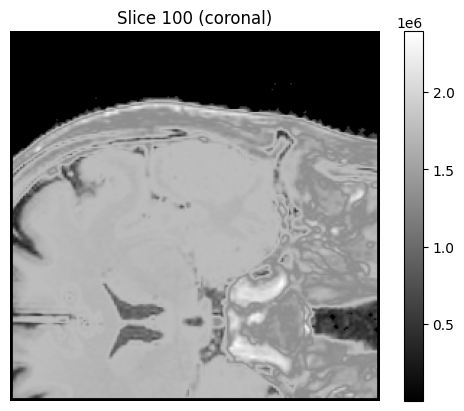

In [17]:
slice_id = 100
axis = 1  # 0: axial, 1: coronal, 2: sagittal

if axis == 0:
    img = Z_vol[slice_id, :, :]
elif axis == 1:
    img = Z_vol[:, slice_id, :]
elif axis == 2:
    img = Z_vol[:, :, slice_id]
else:
    raise ValueError("Axis must be 0 (axial), 1 (coronal), or 2 (sagittal).")

orientation = {0: 'axial', 1: 'coronal', 2: 'sagittal'}.get(axis, 'unknown')

plt.imshow(img.numpy(), cmap='gray')
plt.title(f"Slice {slice_id} ({orientation})")
plt.axis("off")
plt.colorbar()
plt.show()

In [52]:
UR = UltrasoundRenderer(400, 0.0001)

angle = 20  # degrees
rays = 200

thetas = np.radians(np.linspace(-angle,angle, rays))  # 64 rays across the fan
directions = [np.array([np.sin(theta), 0, np.cos(theta)]) for theta in thetas]

tensor([[ 8.,  9.,  8.,  ...,  0.,  0.,  0.],
        [ 8., 10., 11.,  ...,  0.,  0.,  0.],
        [ 7.,  8.,  9.,  ...,  0.,  0.,  0.],
        ...,
        [ 6.,  8., 11.,  ..., 19., 13., 14.],
        [ 8.,  9., 12.,  ..., 20., 13., 15.],
        [11., 10., 11.,  ..., 17., 13., 14.]])

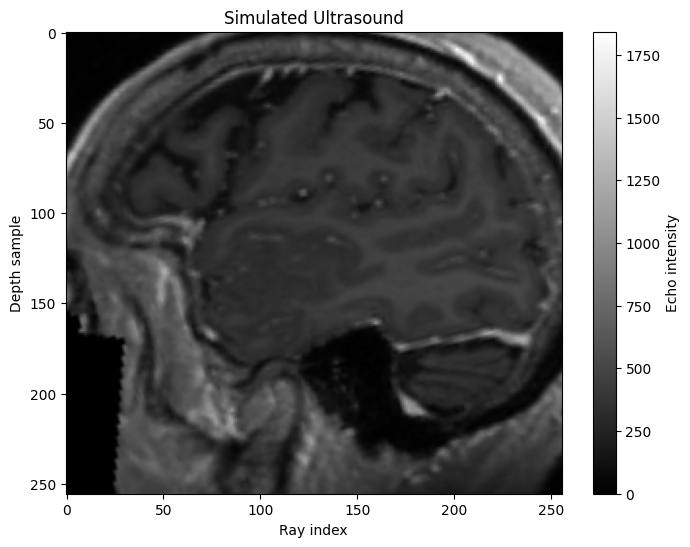

In [51]:
UR.plot_frame(
    T1_volume[100,:,:]
)

Processing rays: 100%|██████████| 200/200 [00:05<00:00, 37.60it/s]


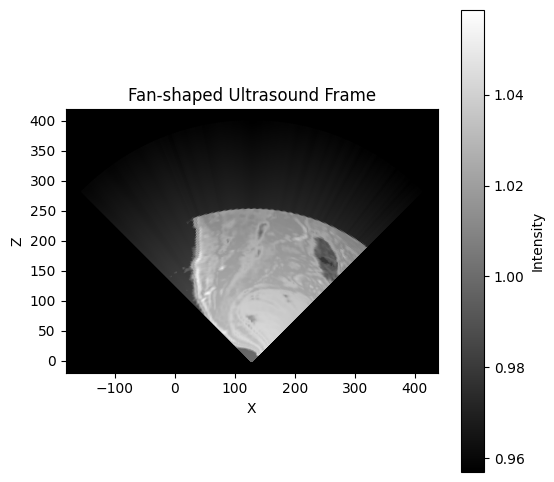

In [54]:
output = UR.plot_beam_frame(
    volume=Z_vol,
    source=torch.tensor([100,40.,0]),
    directions=torch.tensor(directions),
    angle=45
)

# output = UR.plot_beam_frame(
#     volume=T1_volume,
#     source=torch.tensor([100,40.,0]),
#     directions=torch.tensor(directions),
#     angle=45
# )

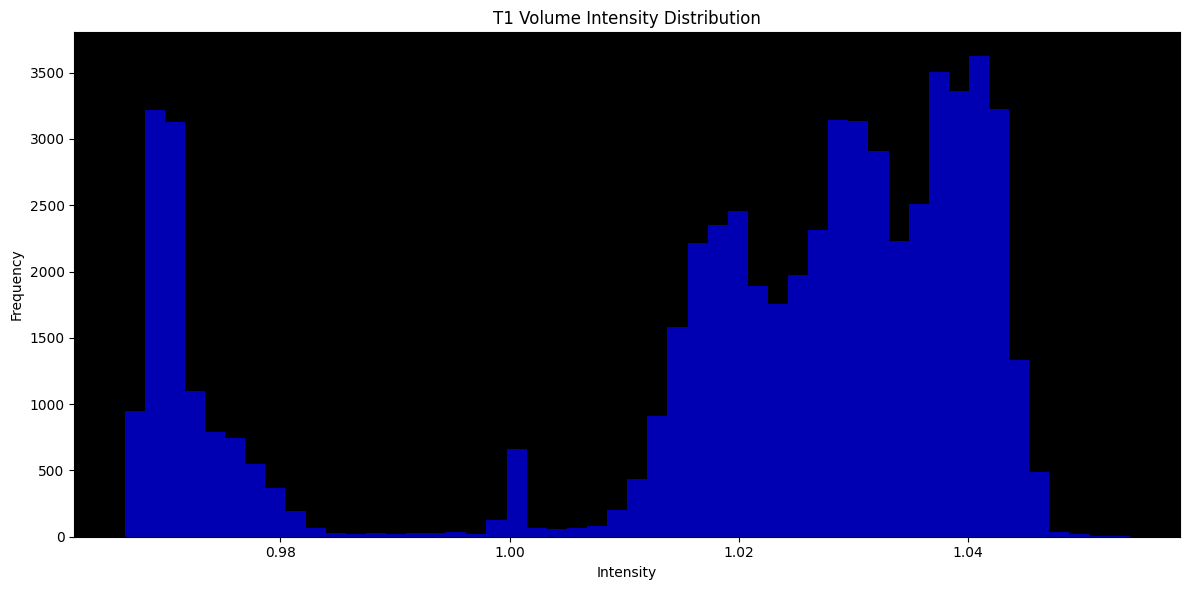

In [33]:
plot_histogram(output)